## Setup

In [1]:
# !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
# import colab_github
# colab_github.github_auth(persistent_key=True)

In [2]:
# # clone repo
# !git clone git@github.com:Nkosana-263/AI-Mavericks-Traffic-Optimisation.git

In [3]:
# %cd /content/AI-Mavericks-Traffic-Optimisation

In [4]:
# # Install required packages
# !pip install pytorch-lightning

In [5]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [6]:
cctv_data = pd.read_csv("/kaggle/input/itu-wtsa/intersection_queue.csv", low_memory=False)
weather_data = pd.read_csv("/kaggle/input/itu-wtsa/weather.csv")

In [7]:
cctv_data["DateTime"] = pd.to_datetime(cctv_data["DateTime"])

In [8]:
cctv_data['DateTime_hour'] = cctv_data['DateTime'].dt.round('H')
# Merge cctv_data and weather_data on the hourly DateTime column
weather_data["date"] = pd.to_datetime(weather_data["date"]).dt.round('H').dt.tz_localize(None)
merged_df = pd.merge(cctv_data, weather_data, left_on='DateTime_hour', right_on='date', how='left')


/tmp/ipykernel_24/276410525.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  cctv_data['DateTime_hour'] = cctv_data['DateTime'].dt.round('H')
/tmp/ipykernel_24/276410525.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_data["date"] = pd.to_datetime(weather_data["date"]).dt.round('H').dt.tz_localize(None)


In [9]:
merged_df

,Unnamed: 0_x,DateTime,Queue Length_link1,Queue Length_link3,Queue Length_link5,Queue Length_link6,DateTime_hour,Unnamed: 0_y,date,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,wind_gusts_10m,cloudcover
0,0,2018-01-01 00:00:00,11,4,4,2,2018-01-01,24,2018-01-01,20.369501,88.02467,0.0,5.351785,9.360000,11.099999
1,1,2018-01-01 00:00:05,6,5,2,1,2018-01-01,24,2018-01-01,20.369501,88.02467,0.0,5.351785,9.360000,11.099999
2,2,2018-01-01 00:00:10,4,3,3,4,2018-01-01,24,2018-01-01,20.369501,88.02467,0.0,5.351785,9.360000,11.099999
3,3,2018-01-01 00:00:15,4,1,1,1,2018-01-01,24,2018-01-01,20.369501,88.02467,0.0,5.351785,9.360000,11.099999
4,4,2018-01-01 00:00:20,5,3,6,0,2018-01-01,24,2018-01-01,20.369501,88.02467,0.0,5.351785,9.360000,11.099999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7003133,7003133,2019-02-22 23:59:40,7,1,6,2,2019-02-23,552,2019-02-23,26.369501,93.13334,0.0,8.707238,11.879999,22.800000
7003134,7003134,2019-02-22 23:59:45,4,0,2,3,2019-02-23,552,2019-02-23,26.369501,93.13334,0.0,8.707238,11.879999,22.800000
7003135,7003135,2019-02-22 23:59:50,4,2,2,3,2019-02-23,552,2019-02-23,26.369501,93.13334,0.0,8.707238,11.879999,22.800000
7003136,7003136,2019-02-22 23:59:55,7,1,4,3,2019-02-23,552,2019-02-23,26.369501,93.13334,0.0,8.707238,11.879999,22.800000


In [10]:
merged_df = merged_df.drop(columns=["Unnamed: 0_x", "DateTime_hour", "Unnamed: 0_y", "date"])

## Define Model

In [11]:
!pip install pytorch-forecasting
!pip install pytorch_optimizer
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 7.0 MB/s eta 0:00:00


In [12]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer, EncoderNormalizer, TorchNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

## Dataloaders

In [13]:
start_date, end_date = "2018-01-01", "2019-01-01"
merged_df = merged_df[(merged_df['DateTime'] >= start_date) & (merged_df['DateTime'] <= end_date)]

In [14]:
len(merged_df)

6087299

In [15]:
# add time index
merged_df["time_idx"] = ((merged_df['DateTime'] - merged_df['DateTime'].min()).dt.total_seconds() // 5).astype(int)


In [16]:
merged_df.columns

Index(['DateTime', 'Queue Length_link1', 'Queue Length_link3',
       'Queue Length_link5', 'Queue Length_link6', 'temperature_2m',
       'relative_humidity_2m', 'precipitation', 'wind_speed_10m',
       'wind_gusts_10m', 'cloudcover', 'time_idx'],
      dtype='object')

In [17]:
data = merged_df.melt(id_vars=['time_idx', 'temperature_2m', 'relative_humidity_2m',
                        'precipitation', 'wind_speed_10m', 'wind_gusts_10m', 'cloudcover'],
                     value_vars=['Queue Length_link1', 'Queue Length_link3', 'Queue Length_link5', 'Queue Length_link6'],
                     var_name='link',
                     value_name='queue_length')

In [18]:
# Create a group column
data['link'] = data['link'].str.replace('Queue Length_', '')  # Remove prefix
# data.rename(columns={'link': 'group'}, inplace=True)

In [19]:
# merged_df["intersection"] ="sathorn"

In [20]:
data["queue_length"] = data["queue_length"].astype(float)

In [21]:
max_prediction_length = 1 * 60 * 12 # 2 hour forecast
max_encoder_length = 12 * 60 * 12 # 24 hours
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    group_ids=["link"],
    target="queue_length",
#     target=["Queue Length_link1", "Queue Length_link3", "Queue Length_link5", "Queue Length_link6"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["link"],
    time_varying_known_reals=["time_idx", "temperature_2m", "relative_humidity_2m",
                              "wind_speed_10m", "wind_gusts_10m"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "queue_length", "cloudcover", "precipitation"
    ],
#     time_varying_unknown_reals=[
#         "Queue Length_link1", "Queue Length_link3", "Queue Length_link5",
#         "Queue Length_link6", "cloudcover", "precipitation",
#     ],
    target_normalizer=GroupNormalizer(
        groups=["link"], transformation="softplus"
    ), 
#     target_normalizer=MultiNormalizer([
#         EncoderNormalizer(),
#         TorchNormalizer()
#     ]
#       ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

In [22]:
# Create validation set, horizon = 2 hours
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# Create dataloaders
batch_size = 16
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size // 2, num_workers=4)

## Train Model

In [23]:
import warnings

warnings.filterwarnings("ignore")

In [24]:
import wandb

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

wb_token = user_secrets.get_secret("WANDB")

wandb.login(key=wb_token)
run = wandb.init(
    project='ITU WTSA-24', 
    job_type="training", 
    anonymous="allow"
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nkosana. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241008_103205-a73kjk5i
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fiery-voice-13
wandb: ⭐️ View project at https://wandb.ai/nkosana/ITU%20WTSA-24
wandb: 🚀 View run at https://wandb.ai/nkosana/ITU%20WTSA-24/runs/a73kjk5i


In [25]:
# configure network and trainer
pl.seed_everything(42)
# trainer = pl.Trainer(
#     accelerator="gpu",
#     gradient_clip_val=0.1,
#     devices=1,
# )

# tft = TemporalFusionTransformer.from_dataset(
#     training,
#     learning_rate=0.03,
#     hidden_size=8,
#     attention_head_size=1,
#     dropout=0.1,
#     hidden_continuous_size=8,
#     loss=QuantileLoss(),
#     optimizer="ranger"
#     # reduce_on_plateau_patience=1000,
# )
# print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: Seed set to 42


42

In [26]:
# # find optimal learning rate
# from lightning.pytorch.tuner import Tuner

# res = Tuner(trainer).lr_find(
#     tft,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
#     max_lr=1e-2,
#     min_lr=1e-6,
# )

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

In [27]:
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint

# configure network and trainer
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1.8e-2,
    patience=10,
    verbose=False,
    mode="min")

# ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",             # Metric to monitor
    dirpath="checkpoints",          # Directory to save checkpoints
    filename="{epoch}-{val_loss:.2f}",  # Checkpoint file name
    save_top_k=1,                  # Save the best 3 models
    mode="min",                     # Mode for the monitored metric ('min' for loss)
)

lr_logger = LearningRateMonitor()

# Initialize Weights & Biases logger
logger = WandbLogger(project="ITU WTSA-24", log_model="all")
# logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=6,
    accelerator="gpu",
#     devices=2,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    accumulate_grad_batches=4,
    limit_train_batches=2200,
    callbacks=[lr_logger, early_stop_callback, checkpoint_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-4,
    hidden_size=8,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    optimizer="ranger",
    reduce_on_plateau_patience=4,
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


Number of parameters in network: 11.2k


In [28]:
# Fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 12     | train
3  | prescalers                         | ModuleDict                      | 192    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.2 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.8 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.4 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 304    | train
8  | static_context_initial_h

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=6` reached.


In [29]:
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇████████
wandb:         lr-Ranger21 ▁▁▁▁▁▁
wandb:    train_loss_epoch █▆▄▂▁▁
wandb:     train_loss_step ▅▆█▆▆▇▆▅▅▆▅▄▄▄▃▅▃▃▄▄▂▃▃▂▃▂▃▂▂▃▃▃▁▃▂▁▂▂▃▂
wandb: trainer/global_step ▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
wandb:             val_MAE █▆▅▄▂▁
wandb:            val_MAPE █▁▁▃▄▅
wandb:            val_RMSE ██▇▄▂▁
wandb:           val_SMAPE ▁██▄▂▁
wandb:            val_loss █▅▂▂▁▁
wandb: 
wandb: Run summary:
wandb:               epoch 5
wandb:         lr-Ranger21 0.0001
wandb:    train_loss_epoch 1.95323
wandb:     train_loss_step 1.79188
wandb: trainer/global_step 3299
wandb:             val_MAE 3.16236
wandb:            val_MAPE 5259137.5
wandb:            val_RMSE 3.83746
wandb:           val_SMAPE 0.69969
wandb:            val_loss 1.6391
wandb: 
wandb: 🚀 View run fiery-voice-13 at: https://wandb.ai/nkosana/ITU%

In [30]:
# !pip install optuna-integration[pytorch_lightning]

In [31]:
# import pickle

# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # save study results - also we can resume tuning at a later point in time
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial.params)

## Model Evaluation

In [32]:
# Load best model
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [33]:
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu", devices=1))
MAE()(predictions.output, predictions.y)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(3.1624, device='cuda:0')

In [34]:
# predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu", devices=1))

# # Extract outputs and targets
# outputs = predictions.output
# targets = predictions.y

# mae_values = []

# # Iterate through each target
# for i in range(len(outputs)):
#     predicted_values = outputs[i]
#     actual_values = targets[0][i]

#     # Calculate Mean Absolute Error (MAE)
#     mae_value = MAE()(predicted_values, actual_values)
#     mae_values.append(mae_value.item())

# average_mae = sum(mae_values) / len(mae_values)

# print(f'MAE for each target: {mae_values}')
# print(f'Average Val MAE: {average_mae}')

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


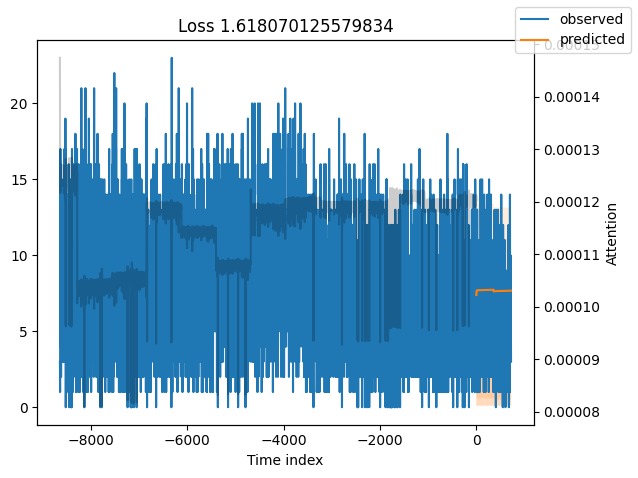

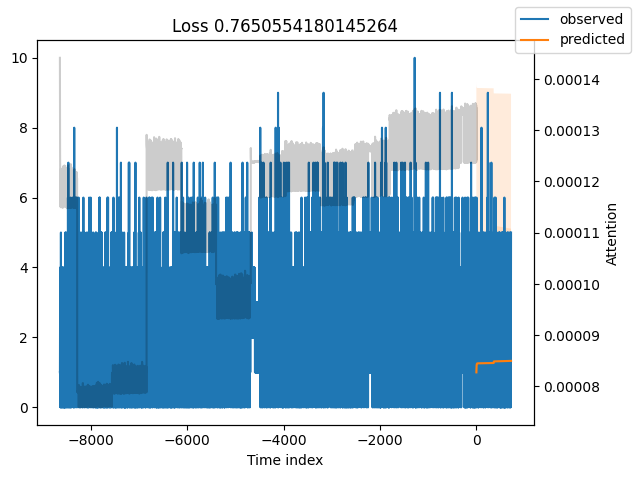

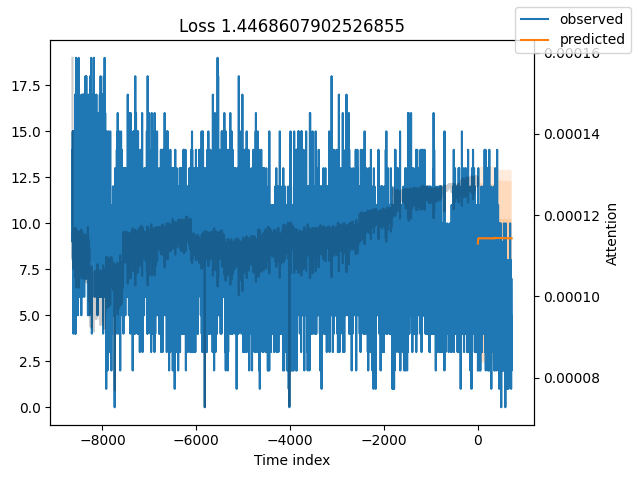

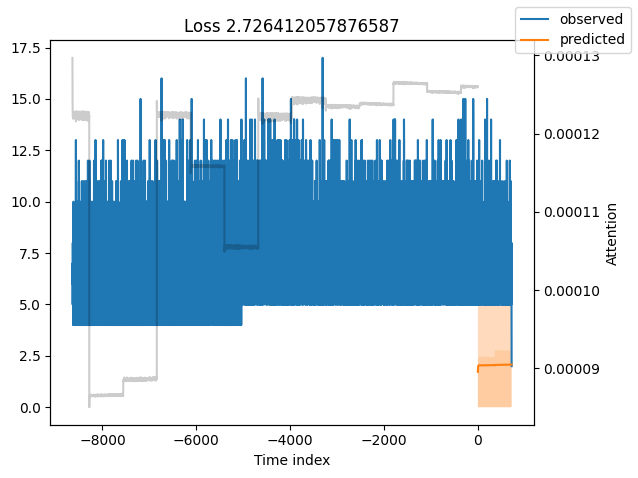

In [35]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", trainer_kwargs=dict(accelerator="gpu", devices=1), return_x=True)

# Get the available number of samples
available_samples = len(raw_predictions.x["encoder_lengths"])

for idx in range(min(24, available_samples)):
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'queue_length_center': <Figure size 1000x500 with 2 Axes>,
 'queue_length_scale': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'temperature_2m': <Figure size 1000x500 with 2 Axes>,
 'relative_humidity_2m': <Figure size 1000x500 with 2 Axes>,
 'wind_speed_10m': <Figure size 1000x500 with 2 Axes>,
 'wind_gusts_10m': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'queue_length': <Figure size 1000x500 with 2 Axes>,
 'cloudcover': <Figure size 1000x500 with 2 Axes>,
 'precipitation': <Figure size 1000x500 with 2 Axes>,
 'link': <Figure size 640x480 with 2 Axes>}

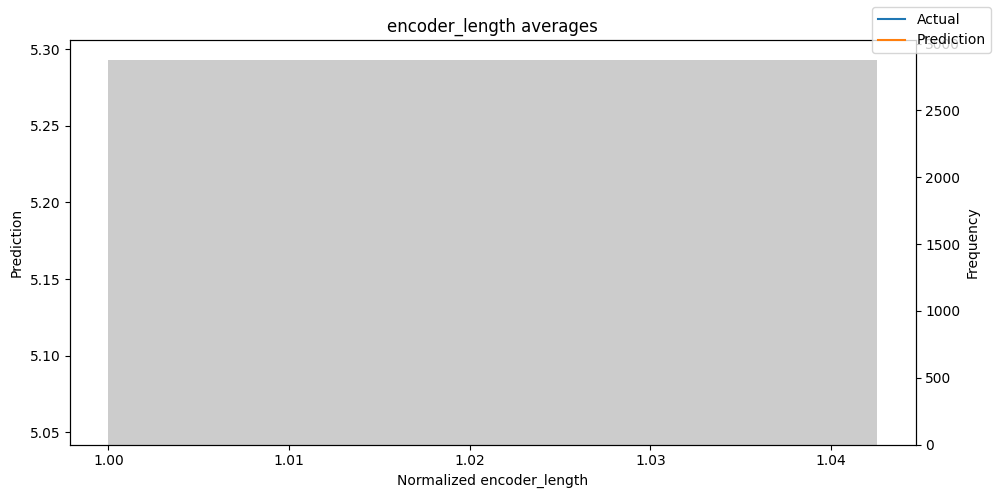

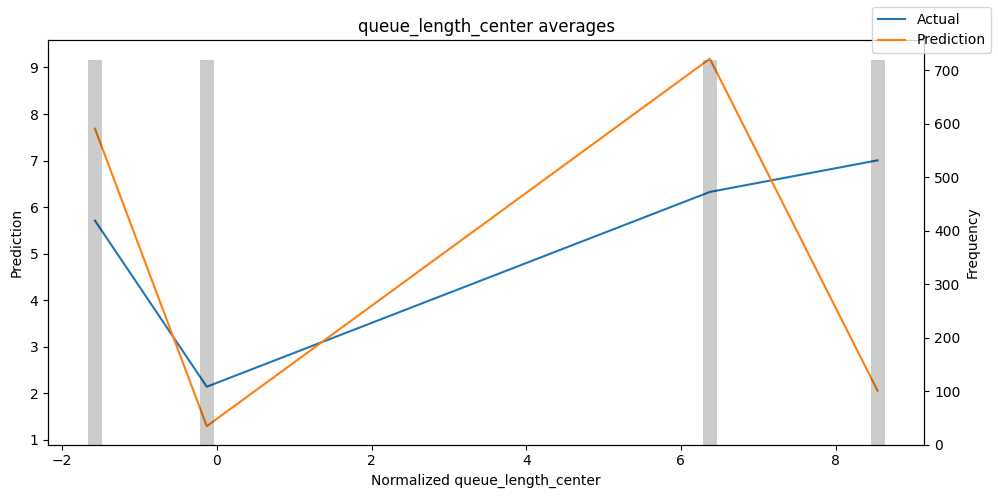

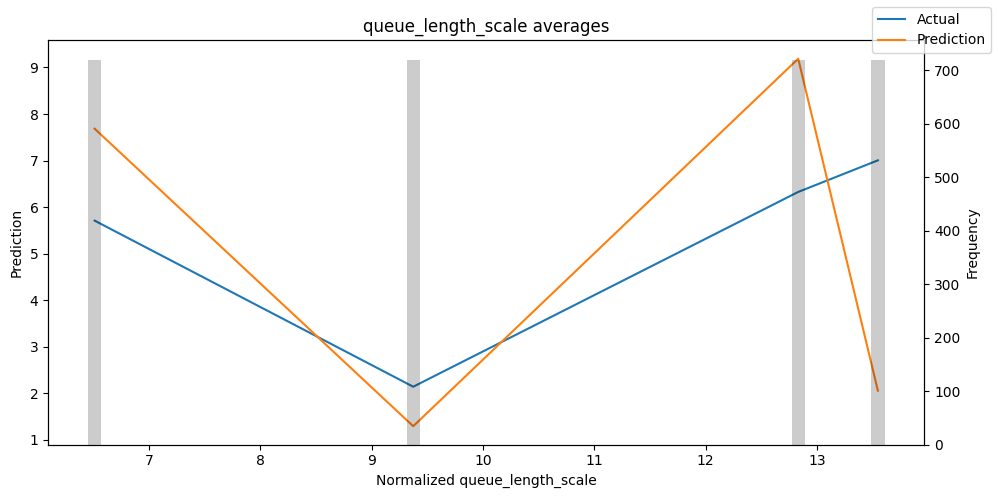

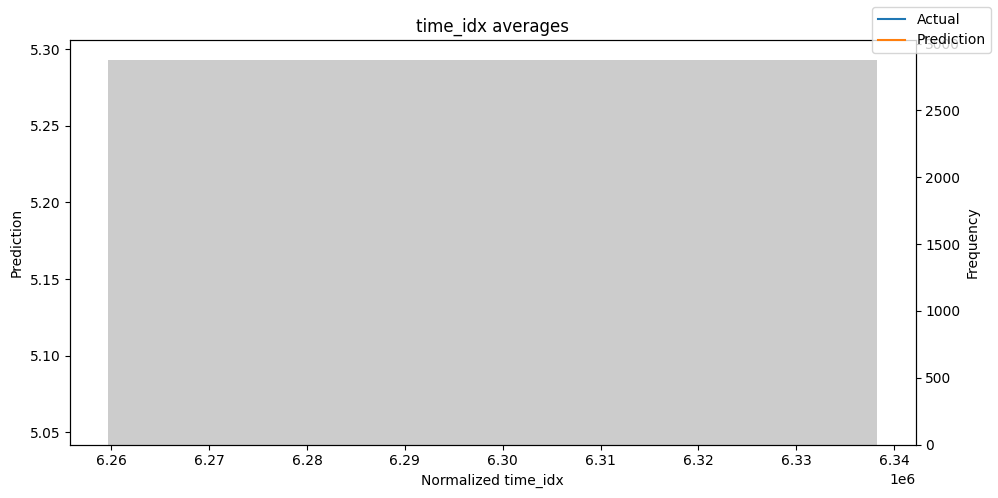

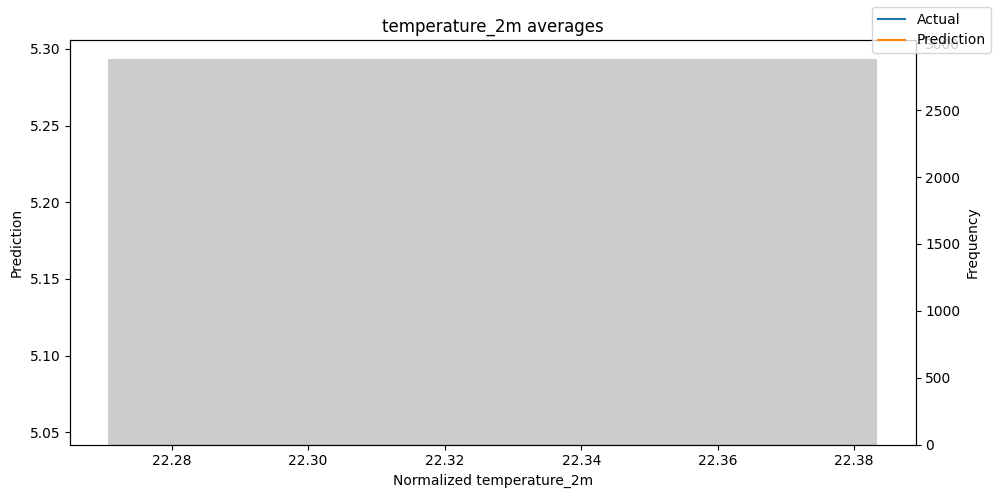

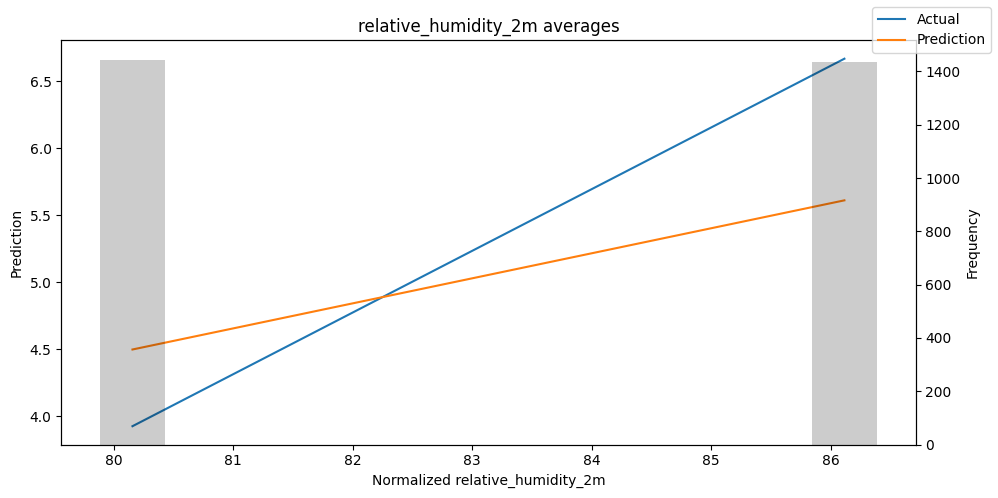

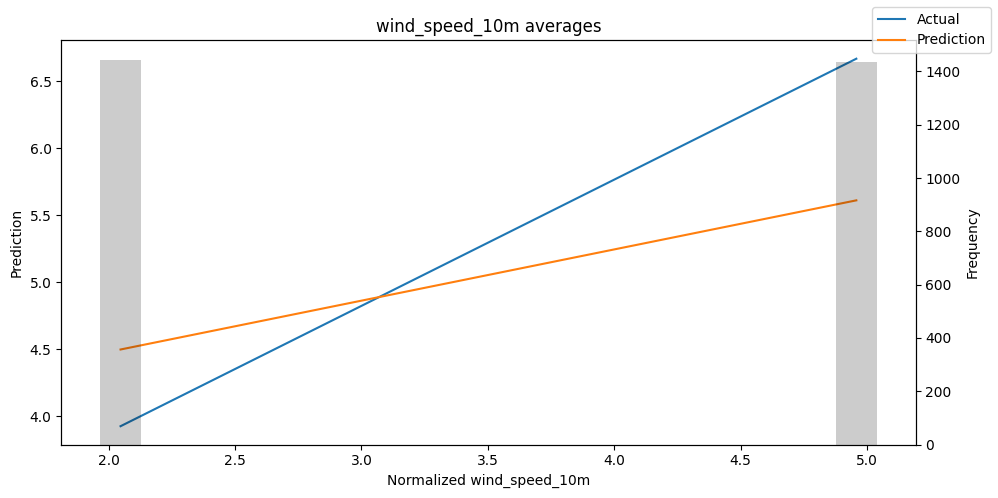

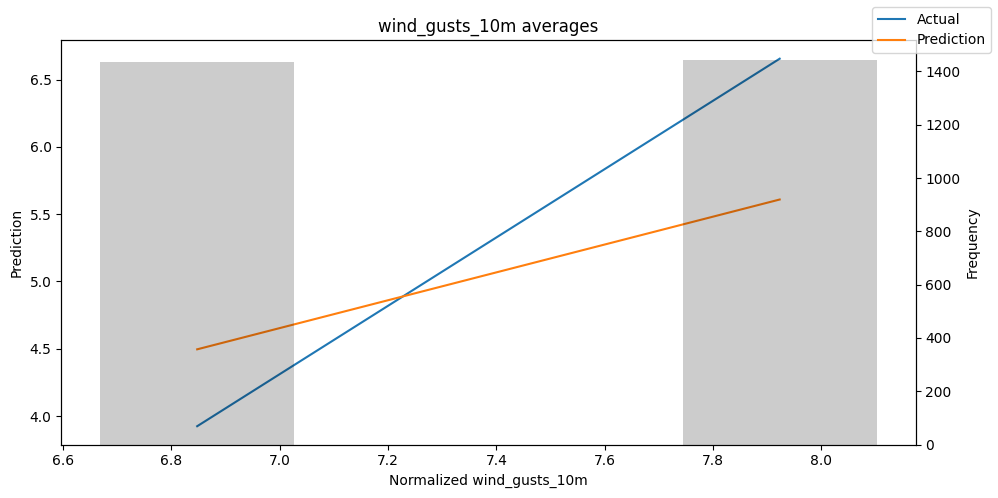

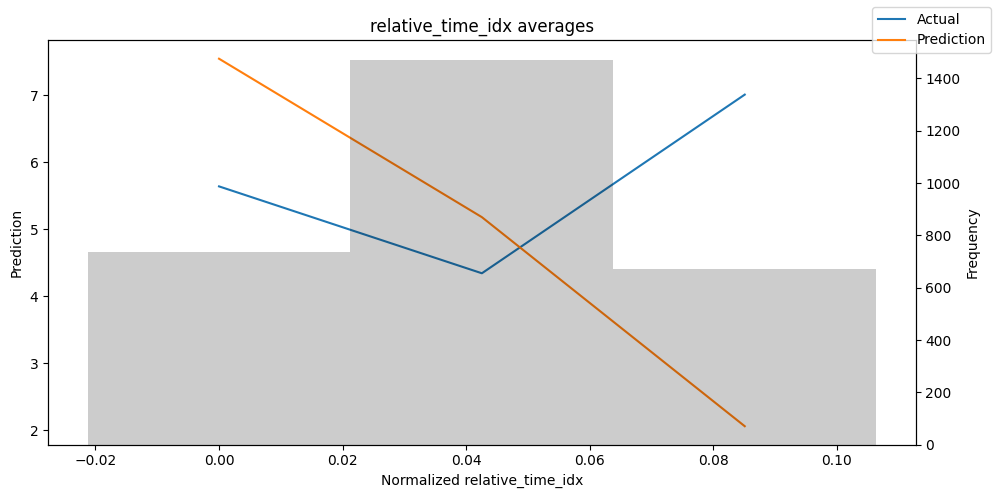

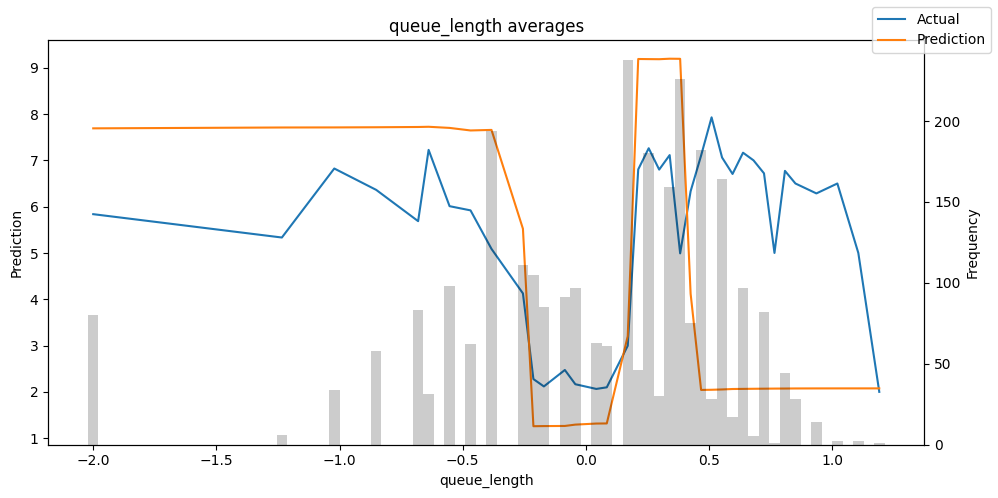

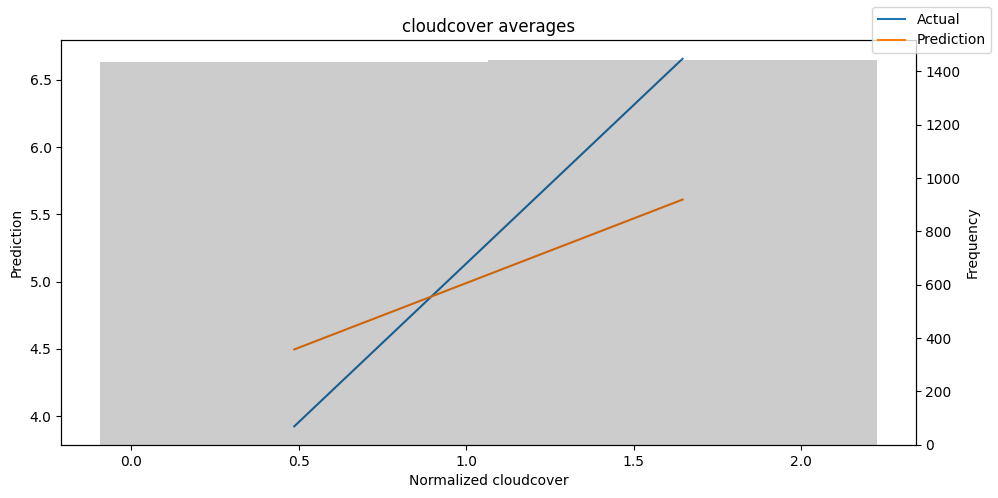

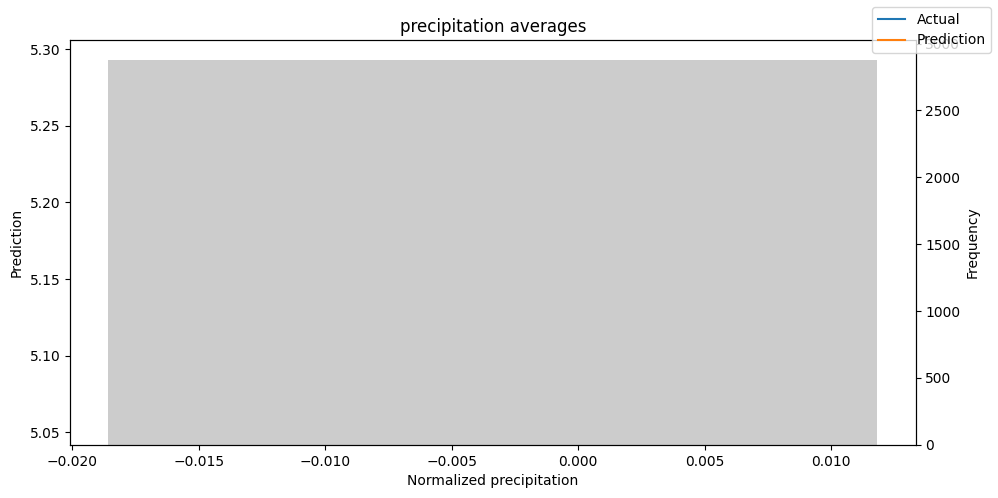

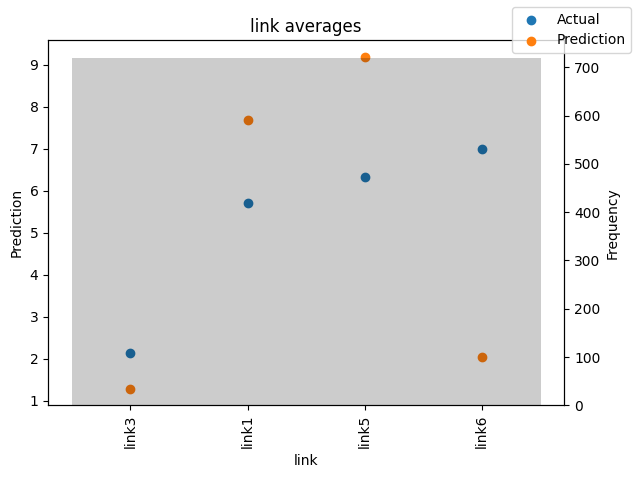

In [36]:
# Actuals vs predictions by variables
predictions = best_tft.predict(val_dataloader, trainer_kwargs=dict(accelerator="gpu", devices=1), return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x425 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

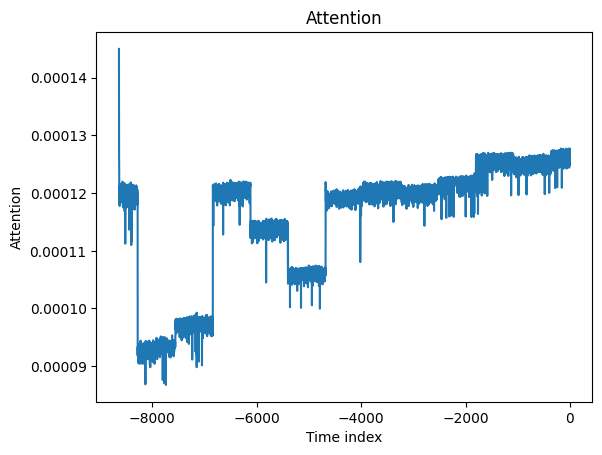

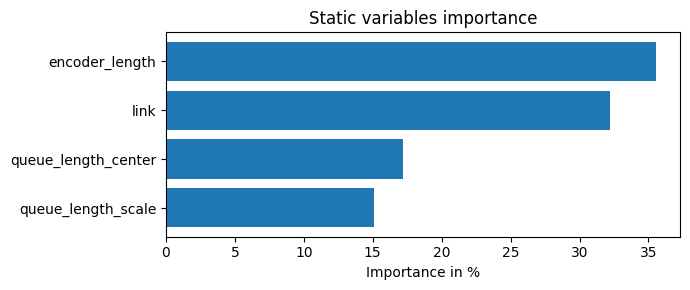

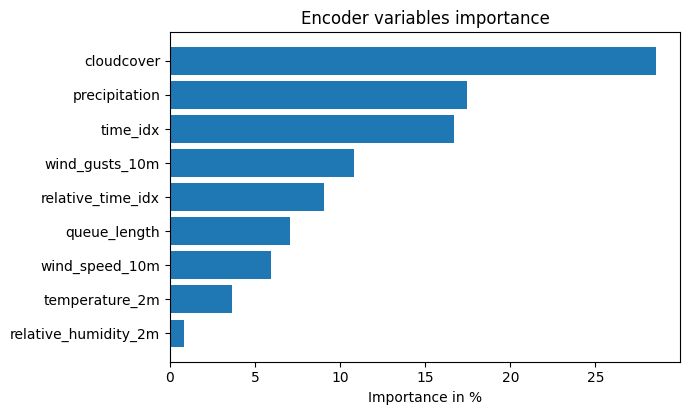

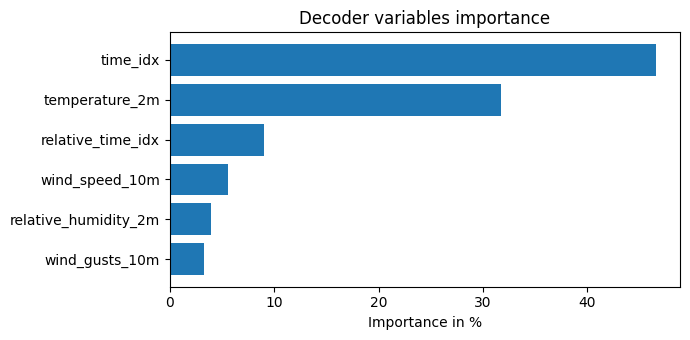

In [37]:
# Variable importance plot
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

Predict:   0%|          | 0/30 [00:00<?, ? batches/s]

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU core

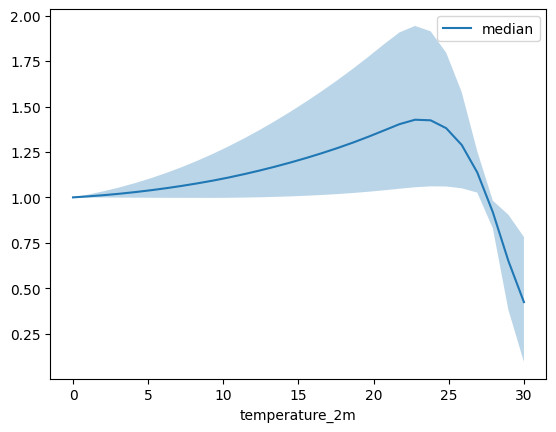

In [38]:
# Partial dependency plot
dependency = best_tft.predict_dependency(
    val_dataloader.dataset, "temperature_2m", np.linspace(0, 30, 30), 
    trainer_kwargs=dict(accelerator="gpu", devices=1), show_progress_bar=True, mode="dataframe"
)

agg_dependency = dependency.groupby("temperature_2m").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3)